In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA, AR, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error 

from statsmodels.tsa.seasonal import seasonal_decompose

import itertools
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv('../data/zillow_data.csv')

In [17]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [18]:
df.dropna(inplace=True)

In [19]:
df_values=df.drop(columns=['RegionID','RegionName','City','State','Metro','CountyName','SizeRank'])

In [20]:
df_values['Monthly Standard Deviation']=df_values.std(axis=1)

In [21]:
df_values.describe()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Monthly Standard Deviation
count,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,...,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04,1.289500e+04
mean,1.212036e+05,1.213271e+05,1.214490e+05,1.215684e+05,1.216994e+05,1.218514e+05,1.220502e+05,1.222816e+05,1.226310e+05,1.230788e+05,...,2.882930e+05,2.900502e+05,2.917727e+05,2.933964e+05,2.951143e+05,2.968218e+05,2.986880e+05,3.010316e+05,3.027098e+05,5.578342e+04
std,8.729561e+04,8.745386e+04,8.761246e+04,8.777632e+04,8.796517e+04,8.819306e+04,8.848098e+04,8.881847e+04,8.926276e+04,8.977167e+04,...,3.123781e+05,3.149425e+05,3.176656e+05,3.200350e+05,3.225833e+05,3.253281e+05,3.279814e+05,3.307702e+05,3.324853e+05,7.135107e+04
min,1.140000e+04,1.150000e+04,1.160000e+04,1.180000e+04,1.180000e+04,1.200000e+04,1.210000e+04,1.220000e+04,1.230000e+04,1.250000e+04,...,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04,2.020296e+03
25%,7.120000e+04,7.140000e+04,7.160000e+04,7.170000e+04,7.180000e+04,7.190000e+04,7.210000e+04,7.230000e+04,7.250000e+04,7.290000e+04,...,1.366000e+05,1.374000e+05,1.381500e+05,1.386500e+05,1.392000e+05,1.397000e+05,1.401000e+05,1.410000e+05,1.418000e+05,1.908575e+04
50%,1.022000e+05,1.023000e+05,1.023000e+05,1.024000e+05,1.025000e+05,1.025000e+05,1.027000e+05,1.029000e+05,1.031000e+05,1.035000e+05,...,2.025000e+05,2.037000e+05,2.052000e+05,2.064000e+05,2.076000e+05,2.085000e+05,2.098000e+05,2.115000e+05,2.130000e+05,3.524312e+04
75%,1.458000e+05,1.459000e+05,1.460000e+05,1.461000e+05,1.461000e+05,1.463000e+05,1.463000e+05,1.466000e+05,1.471000e+05,1.476000e+05,...,3.266000e+05,3.282000e+05,3.300500e+05,3.317500e+05,3.338000e+05,3.357000e+05,3.377000e+05,3.405500e+05,3.422000e+05,6.575038e+04
max,3.676700e+06,3.704200e+06,3.729600e+06,3.754600e+06,3.781800e+06,3.813500e+06,3.849600e+06,3.888900e+06,3.928800e+06,3.964600e+06,...,7.422400e+06,7.417600e+06,7.427300e+06,7.371400e+06,7.342700e+06,7.353300e+06,7.350300e+06,7.363000e+06,7.386600e+06,1.470204e+06


In [22]:
low_std=df_values[df_values['Monthly Standard Deviation']< 5.1785439e+05]
low_std

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Monthly Standard Deviation
0,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,190821.103965
1,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,33537.101427
2,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,...,320600,320200,320400,320800,321200,321200,323000,326900,329900,37730.794353
3,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,...,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,231225.944628
4,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,18167.079218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14716,136200.0,136600.0,136800.0,136800.0,136700.0,136600.0,136400.0,136000.0,135800.0,135800.0,...,332900,335600,338900,340500,341000,342300,345000,348000,349300,93886.550112
14718,94600.0,94300.0,94000.0,93700.0,93400.0,93200.0,93000.0,92900.0,92700.0,92600.0,...,217700,218600,218500,218100,216400,213100,209800,209200,209300,38411.628676
14719,92700.0,92500.0,92400.0,92200.0,92100.0,91900.0,91700.0,91300.0,90900.0,90500.0,...,208400,212200,215200,214300,213100,213700,218300,222700,225800,49298.400500
14720,57100.0,57300.0,57500.0,57700.0,58000.0,58200.0,58400.0,58700.0,59100.0,59500.0,...,122800,124600,126700,128800,130600,131700,132500,133000,133400,17772.324320


In [23]:
low_std.drop(columns=['Monthly Standard Deviation'],inplace=True)


In [24]:
low_std

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,77300.0,77300.0,77300.0,77300.0,77400.0,77500.0,77600.0,77700.0,77700.0,77800.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14716,136200.0,136600.0,136800.0,136800.0,136700.0,136600.0,136400.0,136000.0,135800.0,135800.0,...,332600,332900,335600,338900,340500,341000,342300,345000,348000,349300
14718,94600.0,94300.0,94000.0,93700.0,93400.0,93200.0,93000.0,92900.0,92700.0,92600.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,92700.0,92500.0,92400.0,92200.0,92100.0,91900.0,91700.0,91300.0,90900.0,90500.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,57100.0,57300.0,57500.0,57700.0,58000.0,58200.0,58400.0,58700.0,59100.0,59500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400


In [25]:
low_std['Average Monthly Percent Change']=low_std.pct_change(axis=0).mean(axis=1)

In [26]:
low_std.describe()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Average Monthly Percent Change
count,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,12835.000000,...,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,1.283500e+04,12834.000000
mean,118472.216595,118585.703155,118697.350993,118805.851188,118924.994157,119063.412544,119245.827815,119458.472926,119784.160499,120204.939618,...,2.750008e+05,2.766333e+05,2.782240e+05,2.797418e+05,2.813558e+05,2.829459e+05,2.846986e+05,2.869363e+05,2.885607e+05,0.441670
std,71222.847981,71252.700594,71285.756500,71321.132790,71369.987296,71436.575798,71538.372236,71669.128156,71885.322543,72166.419279,...,2.362982e+05,2.381391e+05,2.400484e+05,2.418370e+05,2.437959e+05,2.458463e+05,2.478647e+05,2.500665e+05,2.514954e+05,1.438489
min,11400.000000,11500.000000,11600.000000,11800.000000,11800.000000,12000.000000,12100.000000,12200.000000,12300.000000,12500.000000,...,1.450000e+04,1.470000e+04,1.480000e+04,1.450000e+04,1.430000e+04,1.410000e+04,1.390000e+04,1.380000e+04,1.380000e+04,-0.951167
25%,71000.000000,71150.000000,71300.000000,71500.000000,71600.000000,71800.000000,72000.000000,72100.000000,72400.000000,72700.000000,...,1.363000e+05,1.370500e+05,1.378500e+05,1.384500e+05,1.389000e+05,1.394000e+05,1.398000e+05,1.407500e+05,1.415000e+05,-0.414354
50%,101800.000000,102000.000000,102000.000000,102200.000000,102100.000000,102200.000000,102200.000000,102400.000000,102800.000000,103100.000000,...,2.018000e+05,2.030000e+05,2.042000e+05,2.053000e+05,2.066000e+05,2.075000e+05,2.088000e+05,2.108000e+05,2.124000e+05,0.027273
75%,145000.000000,145000.000000,145200.000000,145300.000000,145300.000000,145500.000000,145700.000000,145850.000000,146300.000000,146850.000000,...,3.239500e+05,3.255500e+05,3.275500e+05,3.296000e+05,3.314000e+05,3.331500e+05,3.355000e+05,3.380000e+05,3.399000e+05,0.758697
max,841900.000000,847400.000000,852700.000000,857600.000000,862300.000000,866700.000000,871000.000000,874900.000000,879600.000000,885000.000000,...,2.391800e+06,2.395400e+06,2.400900e+06,2.393300e+06,2.396100e+06,2.447500e+06,2.489000e+06,2.533000e+06,2.561200e+06,24.209253


In [27]:
low_std.sort_values(by=['Average Monthly Percent Change'],ascending=False)

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Average Monthly Percent Change
4122,457100.0,457000.0,457500.0,458800.0,460900.0,463800.0,467500.0,472100.0,477300.0,482900.0,...,1902600,1919900,1946900,1990000,2047000,2094100,2123200,2151000,2170600,24.209253
13885,743100.0,746600.0,750000.0,753500.0,757100.0,761000.0,765600.0,770600.0,776900.0,784100.0,...,2391800,2395400,2400900,2393300,2396100,2409600,2430700,2448800,2458000,18.017147
13381,581800.0,585700.0,589600.0,592900.0,595500.0,597500.0,599300.0,601800.0,605900.0,610900.0,...,1101700,1084200,1058800,1041500,1041300,1046300,1048100,1050800,1059600,17.606177
1806,283300.0,284400.0,285700.0,286900.0,288100.0,289300.0,290600.0,291800.0,293400.0,295100.0,...,1214700,1221400,1224800,1230900,1238100,1242600,1248500,1259500,1266500,15.339865
7105,410400.0,410400.0,410400.0,410700.0,411200.0,411900.0,413100.0,414800.0,417100.0,420100.0,...,1558700,1576800,1579800,1577800,1587200,1601400,1616900,1639200,1654200,13.341330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12837,59800.0,60300.0,60800.0,61300.0,61800.0,62400.0,63000.0,63600.0,64300.0,65000.0,...,107700,106300,105100,104800,104800,104900,104800,105200,106000,-0.940297
13653,44800.0,45000.0,45300.0,45500.0,45700.0,45900.0,46200.0,46400.0,46800.0,47300.0,...,89000,89600,89400,90200,92200,93900,93800,93000,92800,-0.942311
8694,27100.0,27200.0,27300.0,27400.0,27500.0,27600.0,27600.0,27700.0,27800.0,28000.0,...,57400,57200,57500,58200,58800,58800,59200,60000,60500,-0.947345
13886,48400.0,48800.0,49200.0,49600.0,49900.0,50300.0,50800.0,51200.0,51700.0,52300.0,...,81900,82100,82900,83700,84200,84100,85800,89900,93400,-0.951167


## Modeling

In [28]:
el_paso_93144 = pd.DataFrame(df_values.iloc[4,:-2])

In [29]:
el_paso_93144

,4
1996-04,77300.0
1996-05,77300.0
1996-06,77300.0
1996-07,77300.0
1996-08,77400.0
...,...
2017-11,120300.0
2017-12,120300.0
2018-01,120300.0
2018-02,120500.0


In [30]:
el_paso_93144 = el_paso_93144.set_index(pd.to_datetime(el_paso_93144.index))

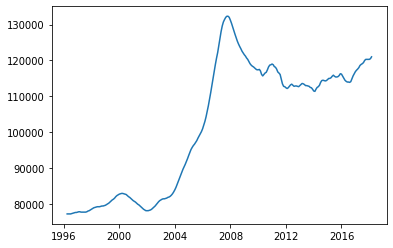

In [32]:
plt.plot(el_paso_93144)

In [33]:
el_paso_93144.rename(columns={4:'value'},inplace=True)

In [ ]:
X = el_paso_93144['value']
train=X[:211]
test=X[211:]